<a href="https://colab.research.google.com/github/ediminished/Data-Preprocessing/blob/main/Data_loader_for_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. For custom dataset given actual images in folders**

### Config and import

In [46]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torchvision.utils import make_grid
from torch.utils.data.dataset import Dataset
from torch.utils.data import WeightedRandomSampler
from PIL import Image

In [88]:
train_dataset_path = './dataset/training/training/'
test_dataset_path = './dataset/validation/validation/'

In [90]:
image_size = 224 

### Download dataset from kaggle using kaggle api

In [1]:
from google.colab import files
# upload the kaggle json file obtained from your kaggle profile
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

User uploaded file "kaggle.json" with length 66 bytes


In [3]:
!rm -r dataset

rm: cannot remove 'dataset': No such file or directory


In [4]:
%mkdir dataset

In [5]:
%cd dataset

/content/dataset


In [6]:
! kaggle datasets download -d slothkong/10-monkey-species

100% 546M/547M [00:03<00:00, 162MB/s]
100% 547M/547M [00:03<00:00, 147MB/s]


In [7]:
%pwd

'/content/dataset'

In [ ]:
!unzip 10-monkey-species.zip

In [179]:
%cd ../

/content


In [180]:
%ls

dataset/  sample_data/


### Transform and create train, validation, test dataset

In [91]:
train_transforms = transforms.Compose([
                                        transforms.Resize((image_size, image_size)), 
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(10),
                                        transforms.ToTensor(),
                                        # transforms.Normalize(mean, std)
                                        ])
val_transforms = transforms.Compose([
                                        transforms.Resize((image_size, image_size)),
                                        transforms.ToTensor(),
                                        # transforms.Normalize(mean, std)
                                        ])
test_transforms = transforms.Compose([
                                        transforms.Resize((image_size, image_size)),
                                        transforms.ToTensor(),
                                        # transforms.Normalize(mean, std)
                                        ])

In [92]:
train__dataset = torchvision.datasets.ImageFolder(root=train_dataset_path, transform = train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root=train_dataset_path, transform = val_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path, transform = test_transforms)

In [ ]:
# Experimental: use this to get mean and std for normalizing the data
def get_mean_std(loader):
    count = 0
    mean = 0.
    std = 0.
    total_images_count = 0
    
    for images, _ in tqdm.tqdm(loader):        
        images = images.view(images.size(0), images.size(1), -1)  #4*3*224*224 ->  4*3*(224*224)
        #Computation of mean across all the pixel for each of the 3 kernels and then summing it over complete batch
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    
    mean /= number_of_samples 
    std /= number_of_samples
    return mean, std
    
# mean, std = get_mean_std(train_loader) 

### Data distribution

In [119]:
train_dataset.classes
type(train_dataset.targets)

list

In [118]:
len(train_dataset.targets)

1097

In [175]:
images_distributions = pd.Series(data=train_dataset.targets)
images_distributions.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [162]:
images_distributions.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [164]:
classes_count = images_distributions.value_counts()
classes_count

3    122
7    114
5    113
1    111
2    110
8    106
6    106
9    105
4    105
0    105
dtype: int64

In [167]:
classes_count_dict = classes_count.to_dict()
classes_count_dict

{0: 105,
 1: 111,
 2: 110,
 3: 122,
 4: 105,
 5: 113,
 6: 106,
 7: 114,
 8: 106,
 9: 105}

In [170]:
# Datasets class
classes_dict = train_dataset.class_to_idx
classes_dict = { v:k for (k,v) in classes_dict.items()}
classes_dict

{0: 'n0',
 1: 'n1',
 2: 'n2',
 3: 'n3',
 4: 'n4',
 5: 'n5',
 6: 'n6',
 7: 'n7',
 8: 'n8',
 9: 'n9'}

In [171]:
count_dict = {classes_dict[k]: v for k, v in classes_count_dict.items()}
count_dict

{'n0': 105,
 'n1': 111,
 'n2': 110,
 'n3': 122,
 'n4': 105,
 'n5': 113,
 'n6': 106,
 'n7': 114,
 'n8': 106,
 'n9': 105}

In [ ]:
sns.barplot()

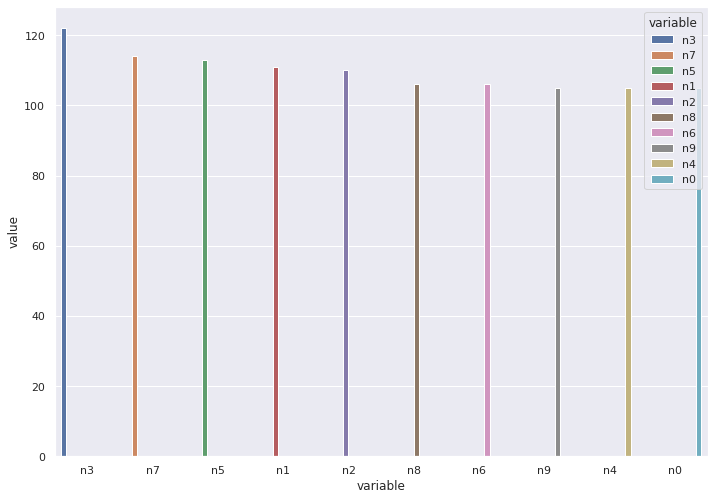

In [176]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=pd.DataFrame.from_dict([count_dict]).melt(),x = "variable", y="value", hue="variable");

Looks like the dataset is very well balanced, so no need for weighted random sampling. Subset randomsampler would suffice.

 In case you have to deal with poorly sampled dataset, here is weighted random sampling

### Dealing with imbalanced datasets:

```WeightedRandomSampler``` is used to ensure that each batch sees a proportional number of all classes

In [189]:
# 1. Get all the target classes
target_list = torch.tensor(train__dataset.targets)
target_list

tensor([0, 0, 0,  ..., 9, 9, 9])

In [190]:
# 2. Shuffle the target classes
target_list_perm = target_list[torch.randperm(len(target_list))]
target_list_perm

tensor([8, 9, 0,  ..., 0, 6, 3])

In [191]:
count_dict.values()

dict_values([122, 114, 113, 111, 110, 106, 106, 105, 105, 105])

In [192]:
# 3. Get the class weights. Class weights are the reciprocal of the number of items per class.
class_count = [ i for i in count_dict.values()]
print(class_count)
class_weights = 1./torch.tensor(class_count, dtype=torch.float)
class_weights

[122, 114, 113, 111, 110, 106, 106, 105, 105, 105]


tensor([0.0082, 0.0088, 0.0088, 0.0090, 0.0091, 0.0094, 0.0094, 0.0095, 0.0095,
        0.0095])

In [195]:
# 4. Obtain corresponding weight for each target sample.
class_weights_all = class_weights[target_list]
class_weights_all

tensor([0.0082, 0.0082, 0.0082,  ..., 0.0095, 0.0095, 0.0095])

In [198]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [ ]:
# train_loader = DataLoader(dataset=natural_img_dataset, shuffle=False, batch_size=8, sampler=weighted_sampler)

### Data loader

In [94]:
validation_size = 0.1

In [113]:
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(validation_size * num_train))
train_idx, val_idx = indices[split:], indices[:split]
print(f"{len(train_idx)}, {len(val_idx)}")

988, 109


In [96]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)

In [79]:
batch_size = 32

In [103]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, sampler=valid_sampler   
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
)

In [111]:
sample = iter(train_loader)
images, classes = sample.next()
print(images.shape, classes.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


images.shape: torch.Size([32, 3, 224, 224])


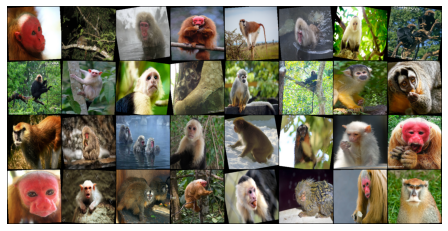

In [177]:
for images, _ in sample:
    print('images.shape:', images.shape)
    plt.figure(figsize=(10, 4))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0))) # move the channel dimension
    break

## **2. For a custom dataset given images in a csv file**

### Config and import

In [51]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torchvision.utils import make_grid
from torch.utils.data.dataset import Dataset
from torch.utils.data import WeightedRandomSampler

In [4]:
image_size = 224 

### Download dataset from kaggle using kaggle api

In [5]:
from google.colab import files
# upload the kaggle json file obtained from your kaggle profile
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

User uploaded file "kaggle.json" with length 66 bytes


In [7]:
!rm -r dataset

In [8]:
%mkdir dataset

In [9]:
%cd dataset

/content/dataset


In [10]:
!kaggle datasets download -d ashishpatel26/fer2018

 82% 79.0M/96.6M [00:01<00:00, 42.2MB/s]
100% 96.6M/96.6M [00:01<00:00, 77.0MB/s]


In [11]:
%pwd

'/content/dataset'

In [12]:
!unzip fer2018.zip

Archive:  fer2018.zip
  inflating: README                  
  inflating: fer2013.bib             
  inflating: fer20131.csv            
  inflating: ferSubmission.csv       


In [13]:
%cd ../

/content


In [14]:
%ls

dataset/  sample_data/


### Read dataset

In [15]:
df = pd.read_csv('./dataset/fer20131.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [16]:
df.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [17]:
standardised_pixels = []
for pix in df.pixels:
  values = [int(i) for i in pix.split()]
  standardised_pixels.append(values)
standardised_pixels = np.array(standardised_pixels)
standardised_pixels = standardised_pixels/255.0
standardised_pixels

array([[0.2745098 , 0.31372549, 0.32156863, ..., 0.41568627, 0.42745098,
        0.32156863],
       [0.59215686, 0.58823529, 0.57647059, ..., 0.75686275, 0.71764706,
        0.72156863],
       [0.90588235, 0.83137255, 0.61176471, ..., 0.34509804, 0.43137255,
        0.59607843],
       ...,
       [0.06666667, 0.06666667, 0.0627451 , ..., 0.60392157, 0.52156863,
        0.44313725],
       [0.11764706, 0.10980392, 0.10980392, ..., 0.1372549 , 0.11764706,
        0.10980392],
       [0.0745098 , 0.05098039, 0.05490196, ..., 0.74117647, 0.78039216,
        0.78823529]])

In [18]:
df.drop(columns=["pixels"], axis=1, inplace=True)
df.head()

,emotion,Usage
0,0,Training
1,0,Training
2,2,Training
3,4,Training
4,6,Training


In [19]:
pix_cols = []
for i in range(standardised_pixels.shape[1]):
  name = f"pixel_{i}"
  pix_cols.append(name)
  df[name] = standardised_pixels[:, i]

In [20]:
df.head()

,emotion,Usage,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,pixel_11,pixel_12,pixel_13,pixel_14,pixel_15,pixel_16,pixel_17,pixel_18,pixel_19,pixel_20,pixel_21,pixel_22,pixel_23,pixel_24,pixel_25,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35,pixel_36,pixel_37,...,pixel_2264,pixel_2265,pixel_2266,pixel_2267,pixel_2268,pixel_2269,pixel_2270,pixel_2271,pixel_2272,pixel_2273,pixel_2274,pixel_2275,pixel_2276,pixel_2277,pixel_2278,pixel_2279,pixel_2280,pixel_2281,pixel_2282,pixel_2283,pixel_2284,pixel_2285,pixel_2286,pixel_2287,pixel_2288,pixel_2289,pixel_2290,pixel_2291,pixel_2292,pixel_2293,pixel_2294,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303
0,0,Training,0.274510,0.313725,0.321569,0.282353,0.227451,0.227451,0.235294,0.247059,0.211765,0.227451,0.235294,0.188235,0.349020,0.450980,0.474510,0.466667,0.450980,0.431373,0.384314,0.356863,0.329412,0.329412,0.352941,0.388235,0.431373,0.494118,0.560784,0.600000,0.619608,0.670588,0.662745,0.674510,0.662745,0.647059,0.505882,0.431373,0.443137,0.419608,...,0.078431,0.121569,0.156863,0.180392,0.254902,0.345098,0.423529,0.431373,0.490196,0.584314,0.615686,0.600000,0.635294,0.643137,0.619608,0.623529,0.603922,0.549020,0.305882,0.082353,0.043137,0.239216,0.564706,0.658824,0.678431,0.615686,0.541176,0.588235,0.580392,0.517647,0.623529,0.713725,0.717647,0.533333,0.415686,0.454902,0.372549,0.415686,0.427451,0.321569
1,0,Training,0.592157,0.588235,0.576471,0.607843,0.580392,0.521569,0.435294,0.549020,0.666667,0.682353,0.713725,0.603922,0.600000,0.643137,0.678431,0.698039,0.725490,0.725490,0.741176,0.733333,0.729412,0.756863,0.760784,0.725490,0.717647,0.729412,0.705882,0.678431,0.650980,0.631373,0.576471,0.521569,0.674510,0.592157,0.447059,0.631373,0.631373,0.572549,...,0.588235,0.505882,0.560784,0.529412,0.450980,0.400000,0.435294,0.486275,0.439216,0.427451,0.517647,0.572549,0.529412,0.584314,0.580392,0.560784,0.639216,0.611765,0.623529,0.588235,0.545098,0.501961,0.454902,0.490196,0.521569,0.427451,0.509804,0.576471,0.509804,0.474510,0.411765,0.423529,0.372549,0.423529,0.400000,0.262745,0.670588,0.756863,0.717647,0.721569
2,2,Training,0.905882,0.831373,0.611765,0.643137,0.682353,0.541176,0.631373,0.678431,0.713725,0.784314,0.415686,0.149020,0.152941,0.290196,0.541176,0.631373,0.643137,0.701961,0.745098,0.788235,0.823529,0.847059,0.862745,0.878431,0.870588,0.854902,0.847059,0.835294,0.850980,0.862745,0.862745,0.854902,0.850980,0.831373,0.682353,0.627451,0.635294,0.627451,...,0.882353,0.862745,0.843137,0.811765,0.780392,0.654902,0.423529,0.592157,0.478431,0.345098,0.278431,0.329412,0.470588,0.498039,0.411765,0.298039,0.278431,0.305882,0.352941,0.415686,0.482353,0.572549,0.607843,0.580392,0.509804,0.552941,0.466667,0.270588,0.211765,0.349020,0.407843,0.541176,0.596078,0.478431,0.447059,0.396078,0.380392,0.345098,0.431373,0.596078
3,4,Training,0.094118,0.125490,0.141176,0.117647,0.125490,0.090196,0.074510,0.078431,0.117647,0.160784,0.082353,0.086275,0.125490,0.133333,0.082353,0.074510,0.168627,0.203922,0.050980,0.101961,0.156863,0.231373,0.254902,0.047059,0.078431,0.247059,0.388235,0.384314,0.384314,0.435294,0.294118,0.243137,0.160784,0.286275,0.462745,0.549020,0.752941,0.729412,...,0.486275,0.588235,0.631373,0.654902,0.662745,0.654902,0.635294,0.643137,0.662745,0.709804,0.674510,0.658824,0.662745,0.666667,0.682353,0.701961,0.705882,0.713725,0.768627,0.815686,0.886275,0.901961,0.549020,0.443137,0.447059,0.490196,0.529412,0.552941,0.674510,0.839216,0.682353,0.494118,0.517647,0.517647,0.521569,0.533333,0.545098,0.556863,0.560784,0.556863
4,6,Training,0.015686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011765,0.058824,0.090196,0.109804,0.188235,0.196078,0.227451,0.329412,0.450980,0.498039,0.537255,0.556863,0.592157,0.611765,0.607843,0.584314,0.600000,0.596078,0.615686,0.627451,0.635294,0.623529,0.568627,0.474

### Dataset transformation

In [21]:
train_transforms = transforms.Compose([
                                       transforms.RandomCrop(48, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomAffine(degrees=0, translate=(0.01, 0.12), shear=(0.01, 0.03)),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       # transforms.Normalize(mean, std)
                                        ])
val_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        # transforms.Normalize(mean, std)
                                        ])
test_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        # transforms.Normalize(mean, std)
                                        ])

### Dataset

In [23]:
class CustomDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform
    # this is applied if transform is set to None
    self.tensor_transform = transforms.ToTensor()

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]
    img_class = int(row['emotion'])
    img = np.copy(row[pix_cols].values.reshape(48, 48))
    img.setflags(write=True)

    if self.transform:
      img = Image.fromarray(img)
      img = self.transform(img)
    else:
      img = self.tensor_transform(img)
    return img, img_class

In [24]:
df.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [25]:
train_dataframe = df[df['Usage'].isin(["Training"])]
train_dataframe = train_dataframe.drop('Usage', axis=1)
train_dataframe.head()

,emotion,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,pixel_11,pixel_12,pixel_13,pixel_14,pixel_15,pixel_16,pixel_17,pixel_18,pixel_19,pixel_20,pixel_21,pixel_22,pixel_23,pixel_24,pixel_25,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35,pixel_36,pixel_37,pixel_38,...,pixel_2264,pixel_2265,pixel_2266,pixel_2267,pixel_2268,pixel_2269,pixel_2270,pixel_2271,pixel_2272,pixel_2273,pixel_2274,pixel_2275,pixel_2276,pixel_2277,pixel_2278,pixel_2279,pixel_2280,pixel_2281,pixel_2282,pixel_2283,pixel_2284,pixel_2285,pixel_2286,pixel_2287,pixel_2288,pixel_2289,pixel_2290,pixel_2291,pixel_2292,pixel_2293,pixel_2294,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303
0,0,0.274510,0.313725,0.321569,0.282353,0.227451,0.227451,0.235294,0.247059,0.211765,0.227451,0.235294,0.188235,0.349020,0.450980,0.474510,0.466667,0.450980,0.431373,0.384314,0.356863,0.329412,0.329412,0.352941,0.388235,0.431373,0.494118,0.560784,0.600000,0.619608,0.670588,0.662745,0.674510,0.662745,0.647059,0.505882,0.431373,0.443137,0.419608,0.372549,...,0.078431,0.121569,0.156863,0.180392,0.254902,0.345098,0.423529,0.431373,0.490196,0.584314,0.615686,0.600000,0.635294,0.643137,0.619608,0.623529,0.603922,0.549020,0.305882,0.082353,0.043137,0.239216,0.564706,0.658824,0.678431,0.615686,0.541176,0.588235,0.580392,0.517647,0.623529,0.713725,0.717647,0.533333,0.415686,0.454902,0.372549,0.415686,0.427451,0.321569
1,0,0.592157,0.588235,0.576471,0.607843,0.580392,0.521569,0.435294,0.549020,0.666667,0.682353,0.713725,0.603922,0.600000,0.643137,0.678431,0.698039,0.725490,0.725490,0.741176,0.733333,0.729412,0.756863,0.760784,0.725490,0.717647,0.729412,0.705882,0.678431,0.650980,0.631373,0.576471,0.521569,0.674510,0.592157,0.447059,0.631373,0.631373,0.572549,0.513725,...,0.588235,0.505882,0.560784,0.529412,0.450980,0.400000,0.435294,0.486275,0.439216,0.427451,0.517647,0.572549,0.529412,0.584314,0.580392,0.560784,0.639216,0.611765,0.623529,0.588235,0.545098,0.501961,0.454902,0.490196,0.521569,0.427451,0.509804,0.576471,0.509804,0.474510,0.411765,0.423529,0.372549,0.423529,0.400000,0.262745,0.670588,0.756863,0.717647,0.721569
2,2,0.905882,0.831373,0.611765,0.643137,0.682353,0.541176,0.631373,0.678431,0.713725,0.784314,0.415686,0.149020,0.152941,0.290196,0.541176,0.631373,0.643137,0.701961,0.745098,0.788235,0.823529,0.847059,0.862745,0.878431,0.870588,0.854902,0.847059,0.835294,0.850980,0.862745,0.862745,0.854902,0.850980,0.831373,0.682353,0.627451,0.635294,0.627451,0.545098,...,0.882353,0.862745,0.843137,0.811765,0.780392,0.654902,0.423529,0.592157,0.478431,0.345098,0.278431,0.329412,0.470588,0.498039,0.411765,0.298039,0.278431,0.305882,0.352941,0.415686,0.482353,0.572549,0.607843,0.580392,0.509804,0.552941,0.466667,0.270588,0.211765,0.349020,0.407843,0.541176,0.596078,0.478431,0.447059,0.396078,0.380392,0.345098,0.431373,0.596078
3,4,0.094118,0.125490,0.141176,0.117647,0.125490,0.090196,0.074510,0.078431,0.117647,0.160784,0.082353,0.086275,0.125490,0.133333,0.082353,0.074510,0.168627,0.203922,0.050980,0.101961,0.156863,0.231373,0.254902,0.047059,0.078431,0.247059,0.388235,0.384314,0.384314,0.435294,0.294118,0.243137,0.160784,0.286275,0.462745,0.549020,0.752941,0.729412,0.733333,...,0.486275,0.588235,0.631373,0.654902,0.662745,0.654902,0.635294,0.643137,0.662745,0.709804,0.674510,0.658824,0.662745,0.666667,0.682353,0.701961,0.705882,0.713725,0.768627,0.815686,0.886275,0.901961,0.549020,0.443137,0.447059,0.490196,0.529412,0.552941,0.674510,0.839216,0.682353,0.494118,0.517647,0.517647,0.521569,0.533333,0.545098,0.556863,0.560784,0.556863
4,6,0.015686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011765,0.058824,0.090196,0.109804,0.188235,0.196078,0.227451,0.329412,0.450980,0.498039,0.537255,0.556863,0.592157,0.611765,0.607843,0.584314,0.600000,0.596078,0.615686,0.627451,0.635294,0.623529,0.568627,0.474510,0.

In [26]:
val_dataframe = df[df["Usage"].isin(["PublicTest"])]
val_dataframe = val_dataframe.drop('Usage', axis=1)
val_dataframe.head()

,emotion,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,pixel_11,pixel_12,pixel_13,pixel_14,pixel_15,pixel_16,pixel_17,pixel_18,pixel_19,pixel_20,pixel_21,pixel_22,pixel_23,pixel_24,pixel_25,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35,pixel_36,pixel_37,pixel_38,...,pixel_2264,pixel_2265,pixel_2266,pixel_2267,pixel_2268,pixel_2269,pixel_2270,pixel_2271,pixel_2272,pixel_2273,pixel_2274,pixel_2275,pixel_2276,pixel_2277,pixel_2278,pixel_2279,pixel_2280,pixel_2281,pixel_2282,pixel_2283,pixel_2284,pixel_2285,pixel_2286,pixel_2287,pixel_2288,pixel_2289,pixel_2290,pixel_2291,pixel_2292,pixel_2293,pixel_2294,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303
28709,0,0.996078,0.996078,0.996078,0.996078,0.996078,0.976471,1.000000,0.627451,0.007843,0.227451,0.207843,0.274510,0.301961,0.298039,0.294118,0.305882,0.266667,0.070588,0.125490,0.113725,0.000000,0.211765,0.286275,0.294118,0.282353,0.266667,0.294118,0.301961,0.298039,0.298039,0.294118,0.313725,0.200000,0.141176,0.184314,0.156863,0.172549,0.164706,0.145098,...,0.098039,0.792157,0.780392,0.227451,0.960784,0.909804,0.247059,0.560784,0.945098,0.803922,0.827451,0.839216,0.839216,0.827451,0.823529,0.823529,0.831373,0.862745,0.831373,0.501961,0.505882,0.784314,0.709804,0.482353,0.219608,0.349020,0.372549,0.337255,0.188235,0.352941,0.352941,0.360784,0.388235,0.329412,0.086275,0.000000,0.000000,0.164706,0.505882,0.705882
28710,1,0.611765,0.721569,0.776471,0.792157,0.800000,0.811765,0.823529,0.831373,0.835294,0.839216,0.843137,0.839216,0.839216,0.835294,0.847059,0.850980,0.854902,0.850980,0.847059,0.839216,0.835294,0.839216,0.835294,0.839216,0.843137,0.827451,0.811765,0.803922,0.800000,0.792157,0.776471,0.764706,0.756863,0.745098,0.721569,0.705882,0.690196,0.682353,0.674510,...,0.356863,0.525490,0.000000,0.031373,0.019608,0.019608,0.023529,0.027451,0.015686,0.019608,0.031373,0.007843,0.047059,0.552941,0.737255,0.745098,0.756863,0.752941,0.784314,0.807843,0.815686,0.811765,0.807843,0.803922,0.800000,0.807843,0.807843,0.807843,0.807843,0.800000,0.788235,0.780392,0.772549,0.756863,0.737255,0.721569,0.705882,0.674510,0.654902,0.631373
28711,4,0.270588,0.462745,0.239216,0.235294,0.376471,0.474510,0.403922,0.341176,0.403922,0.345098,0.274510,0.352941,0.450980,0.478431,0.482353,0.486275,0.505882,0.517647,0.521569,0.513725,0.513725,0.474510,0.443137,0.431373,0.396078,0.392157,0.388235,0.447059,0.443137,0.411765,0.415686,0.419608,0.470588,0.482353,0.486275,0.509804,0.541176,0.529412,0.533333,...,0.439216,0.364706,0.627451,0.623529,0.549020,0.533333,0.517647,0.478431,0.447059,0.454902,0.505882,0.501961,0.494118,0.498039,0.478431,0.458824,0.431373,0.431373,0.427451,0.431373,0.458824,0.470588,0.470588,0.478431,0.498039,0.501961,0.494118,0.447059,0.396078,0.368627,0.364706,0.364706,0.360784,0.352941,0.360784,0.364706,0.360784,0.345098,0.341176,0.352941
28712,6,0.803922,0.796078,0.925490,0.615686,0.325490,0.619608,0.470588,0.454902,0.368627,0.337255,0.607843,0.705882,0.803922,0.905882,0.858824,0.850980,0.745098,0.776471,0.815686,0.682353,0.623529,0.654902,0.827451,0.901961,0.843137,0.819608,0.764706,0.823529,0.792157,0.729412,0.733333,0.713725,0.725490,0.866667,0.898039,0.890196,0.854902,0.784314,0.752941,...,0.588235,0.623529,0.670588,0.694118,0.694118,0.698039,0.713725,0.713725,0.709804,0.709804,0.705882,0.701961,0.709804,0.713725,0.705882,0.713725,0.713725,0.721569,0.756863,0.772549,0.776471,0.792157,0.796078,0.800000,0.800000,0.752941,0.631373,0.458824,0.721569,0.854902,0.811765,0.827451,0.835294,0.807843,0.768627,0.709804,0.439216,0.168627,0.321569,0.337255
28713,3,0.341176,0.309804,0.290196,0.258824,0.290196,0.376471,0.301961,0.313725,0.313725,0.329412,0.325490,0.349020,0.400000,0.356863,0.329412,0.400000,0.423529,0.419608,0.400000,0.349020,0.376471,0.501961,0.596078,0.690196,0.764706,0.811765,0.839216,0.862745,0.870588,0.878431,0.870588,0.862745,0.847059,0.839216,

In [27]:
test_dataframe = df[df["Usage"].isin(["PrivateTest"])]
test_dataframe = test_dataframe.drop('Usage', axis=1)
test_dataframe.head()

,emotion,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,pixel_11,pixel_12,pixel_13,pixel_14,pixel_15,pixel_16,pixel_17,pixel_18,pixel_19,pixel_20,pixel_21,pixel_22,pixel_23,pixel_24,pixel_25,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35,pixel_36,pixel_37,pixel_38,...,pixel_2264,pixel_2265,pixel_2266,pixel_2267,pixel_2268,pixel_2269,pixel_2270,pixel_2271,pixel_2272,pixel_2273,pixel_2274,pixel_2275,pixel_2276,pixel_2277,pixel_2278,pixel_2279,pixel_2280,pixel_2281,pixel_2282,pixel_2283,pixel_2284,pixel_2285,pixel_2286,pixel_2287,pixel_2288,pixel_2289,pixel_2290,pixel_2291,pixel_2292,pixel_2293,pixel_2294,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303
32298,0,0.666667,0.462745,0.396078,0.345098,0.345098,0.294118,0.305882,0.321569,0.258824,0.290196,0.266667,0.231373,0.247059,0.250980,0.254902,0.352941,0.349020,0.286275,0.313725,0.313725,0.333333,0.345098,0.372549,0.458824,0.517647,0.572549,0.545098,0.596078,0.643137,0.709804,0.713725,0.760784,0.764706,0.635294,0.556863,0.576471,0.592157,0.580392,0.619608,...,0.258824,0.266667,0.384314,0.345098,0.298039,0.372549,0.447059,0.400000,0.427451,0.450980,0.474510,0.509804,0.545098,0.556863,0.568627,0.576471,0.584314,0.588235,0.615686,0.658824,0.658824,0.658824,0.654902,0.627451,0.564706,0.501961,0.494118,0.470588,0.439216,0.560784,0.823529,0.823529,0.870588,0.870588,0.800000,0.745098,0.682353,0.623529,0.521569,0.513725
32299,5,0.027451,0.019608,0.031373,0.023529,0.027451,0.011765,0.007843,0.023529,0.019608,0.015686,0.015686,0.019608,0.027451,0.019608,0.019608,0.019608,0.023529,0.027451,0.027451,0.027451,0.039216,0.039216,0.031373,0.023529,0.031373,0.043137,0.047059,0.058824,0.035294,0.027451,0.062745,0.082353,0.035294,0.031373,0.050980,0.070588,0.090196,0.078431,0.090196,...,0.043137,0.109804,0.074510,0.047059,0.047059,0.043137,0.035294,0.035294,0.043137,0.039216,0.039216,0.054902,0.070588,0.074510,0.070588,0.054902,0.070588,0.094118,0.082353,0.050980,0.078431,0.227451,0.321569,0.352941,0.364706,0.352941,0.341176,0.309804,0.333333,0.294118,0.160784,0.145098,0.298039,0.345098,0.329412,0.345098,0.321569,0.282353,0.223529,0.203922
32300,6,0.909804,0.941176,0.945098,0.937255,0.929412,0.921569,0.964706,0.458824,0.094118,0.094118,0.086275,0.050980,0.047059,0.054902,0.035294,0.031373,0.019608,0.023529,0.031373,0.035294,0.035294,0.027451,0.027451,0.023529,0.015686,0.015686,0.015686,0.019608,0.027451,0.015686,0.039216,0.047059,0.047059,0.058824,0.078431,0.054902,0.066667,0.141176,0.807843,...,0.682353,0.596078,0.556863,0.392157,0.109804,0.113725,0.105882,0.109804,0.098039,0.305882,0.078431,0.000000,0.070588,0.094118,0.043137,0.074510,0.141176,0.137255,0.145098,0.117647,0.219608,0.784314,0.815686,0.635294,0.149020,0.396078,0.356863,0.294118,0.419608,0.545098,0.250980,0.082353,0.349020,0.266667,0.180392,0.262745,0.007843,0.015686,0.015686,0.035294
32301,4,0.784314,0.772549,0.584314,0.545098,0.611765,0.349020,0.435294,0.227451,0.243137,0.372549,0.443137,0.458824,0.454902,0.454902,0.439216,0.435294,0.376471,0.337255,0.388235,0.443137,0.470588,0.458824,0.454902,0.427451,0.447059,0.490196,0.517647,0.533333,0.533333,0.517647,0.501961,0.501961,0.525490,0.517647,0.517647,0.533333,0.541176,0.537255,0.525490,...,0.309804,0.349020,0.388235,0.411765,0.415686,0.450980,0.458824,0.478431,0.525490,0.545098,0.537255,0.560784,0.580392,0.584314,0.584314,0.592157,0.576471,0.584314,0.615686,0.619608,0.572549,0.568627,0.576471,0.537255,0.533333,0.521569,0.501961,0.501961,0.478431,0.501961,0.556863,0.631373,0.725490,0.725490,0.419608,0.572549,0.564706,0.584314,0.129412,0.000000
32302,2,0.156863,0.109804,0.129412,0.219608,0.176471,0.129412,0.121569,0.305882,0.596078,0.760784,0.784314,0.729412,0.768627,0.811765,0.760784,0.725490,0.772549,0.725490,0.690196,0.654902,0.650980,0.635294,0.627451,0.592157,0.568627,0.556863,0.529412,0.525490,0.525490,0.513725,0.490196,0.478431,0.396078,0.282353,

In [28]:
print(train_dataframe.shape, val_dataframe.shape, test_dataframe.shape)

(28709, 2305) (3589, 2305) (3589, 2305)


In [29]:
train_dataset = CustomDataset(train_dataframe, transform=train_transforms)
val_dataset = CustomDataset(val_dataframe, transform=val_transforms)
test_dataset = CustomDataset(test_dataframe, transform=test_transforms)

In [30]:
len(train_dataset)

28709

### Dataset distribution

In [31]:
train_dataset.df.emotion.value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

In [32]:
train_dataset.df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [33]:
print(type(train_dataset.df.emotion))
print(train_dataset.df.emotion)

<class 'pandas.core.series.Series'>
0        0
1        0
2        2
3        4
4        6
        ..
28704    2
28705    0
28706    4
28707    0
28708    4
Name: emotion, Length: 28709, dtype: int64


In [34]:
images_distributions = train_dataset.df.emotion
images_distributions

0        0
1        0
2        2
3        4
4        6
        ..
28704    2
28705    0
28706    4
28707    0
28708    4
Name: emotion, Length: 28709, dtype: int64

In [35]:
images_distributions.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [36]:
classes_count = images_distributions.value_counts()
classes_count

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

In [37]:
classes_count_dict = classes_count.to_dict()
classes_count_dict

{0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4830, 5: 3171, 6: 4965}

In [38]:
#Dataset class:
emotions = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

In [39]:
count_dict = {emotions[k]: v for k, v in classes_count_dict.items()}

In [40]:
count_dict 

{'Angry': 3995,
 'Disgust': 436,
 'Fear': 4097,
 'Happy': 7215,
 'Neutral': 4965,
 'Sad': 4830,
 'Surprise': 3171}

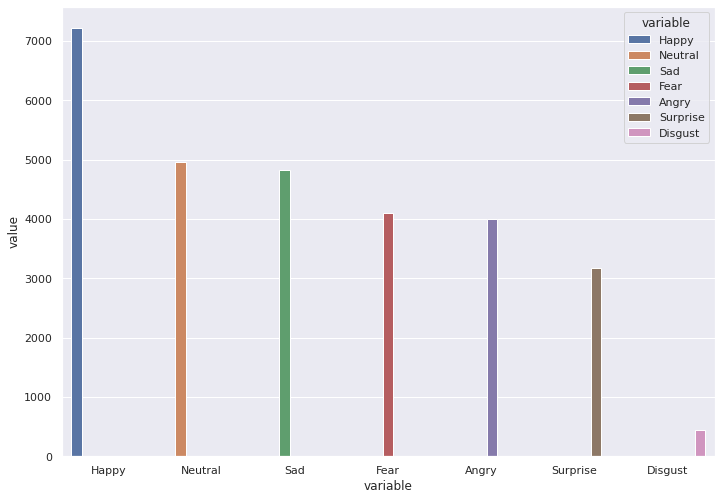

In [41]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=pd.DataFrame.from_dict([count_dict]).melt(),x = "variable", y="value", hue="variable");

Clearly the dataset looks poorly balanced. 
So, we should use weighted random sampling for a data loader

### Handling imbalanced dataset
```WeightedRandomSampler``` is used to ensure that each batch sees a proportional number of all classes

In [150]:
classes_count_dict

{0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4830, 5: 3171, 6: 4965}

In [172]:
class_weight_new = {k:1./(v) for k,v in classes_count_dict.items()}

In [198]:
# more is the count lesser is the class_weight
class_weight_new

{0: 0.00025031289111389235,
 1: 0.0022935779816513763,
 2: 0.000244081034903588,
 3: 0.0001386001386001386,
 4: 0.00020703933747412008,
 5: 0.000315357931251971,
 6: 0.0002014098690835851}

In [171]:
sample_weights = [0]* len(train_dataset)
len(sample_weights)

28709

In [175]:
# associating class_weight to each item in train_dataset
for idx, (data, label)  in enumerate(train_dataset):
  class_weight = class_weight_new[label]
  sample_weights[idx] = class_weight

In [176]:
# This is ready to rock, for the equity!! Say NO to bias :)
sample_weights = torch.Tensor(sample_weights)

In [177]:
len(sample_weights)

28709

In [178]:
weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

### Data Loader

In [179]:
batch_size = 32

In [180]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=weighted_sampler
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(data_source= val_dataset, replacement=True)   
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
)

In [194]:
sample = iter(train_loader)
images, classes = sample.next()
print(images.shape, classes.shape)

torch.Size([32, 1, 48, 48]) torch.Size([32])


images.shape: torch.Size([32, 1, 48, 48])


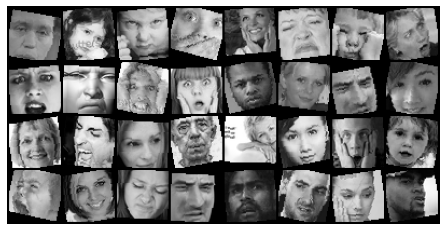

In [195]:
for images, _ in sample:
    print('images.shape:', images.shape)
    plt.figure(figsize=(10, 4))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0))) # move the channel dimension
    break

In [196]:
my = pd.Series(classes)

In [197]:
my.value_counts()

1    10
0     6
4     5
2     4
6     3
3     3
5     1
dtype: int64

# That's it